In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import DDPMPipeline
from datasets import load_dataset
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers import UNet2DModel
import gc
from tqdm.auto import tqdm
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
def _empty_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [5]:
pipeline = DDPMPipeline.from_pretrained("johnowhitaker/sd-class-wikiart-from-bedrooms").to(device)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
scheduler = DDIMScheduler.from_pretrained("johnowhitaker/sd-class-wikiart-from-bedrooms")

In [7]:
scheduler.set_timesteps(num_inference_steps=40)

  0%|          | 0/40 [00:00<?, ?it/s]

CPU times: user 40.2 s, sys: 343 ms, total: 40.5 s
Wall time: 40.4 s


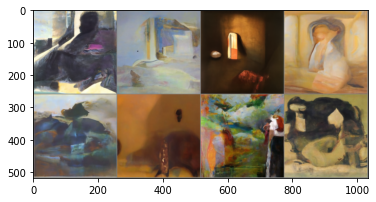

In [8]:
%%time


x = torch.randn(8, 3, 256, 256).to(device)

for i, t in enumerate(tqdm(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = pipeline.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
    
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1)*0.5 + 0.5)

In [10]:
_empty_cache()

In [18]:
def color_loss(images, target_color=(0.5, 0.1, 0.6)):
    target = torch.tensor(target_color, device=images.device)*2 -1
    target = target[None, :, None, None]
    error = torch.abs(images - target).mean()
    return error

In [22]:
%%time

guidance_loss_scale = 40

x = torch.randn(4, 3, 256, 256).to(device)

for i, t in enumerate(tqdm(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = pipeline.unet(model_input, t)["sample"]

    x = x.detach().requires_grad_()
    
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample
    
    loss = color_loss(x0)*guidance_loss_scale
    print(f"Step: {i},  loss: {loss.item()}")
    
    cond_grad = -torch.autograd.grad(loss, x)[0]
    x = x.detach() + cond_grad
    x = scheduler.step(noise_pred, t, x).prev_sample

  0%|          | 0/40 [00:00<?, ?it/s]

Step: 0,  loss: 22.109607696533203
Step: 1,  loss: 16.259479522705078
Step: 2,  loss: 10.99825382232666
Step: 3,  loss: 7.212612152099609
Step: 4,  loss: 5.088639259338379
Step: 5,  loss: 3.771101951599121
Step: 6,  loss: 3.084392547607422
Step: 7,  loss: 2.6931405067443848
Step: 8,  loss: 2.593719720840454
Step: 9,  loss: 2.4533402919769287
Step: 10,  loss: 2.4009571075439453
Step: 11,  loss: 2.321596384048462
Step: 12,  loss: 2.2281713485717773
Step: 13,  loss: 2.0395641326904297
Step: 14,  loss: 1.948617935180664
Step: 15,  loss: 1.8793076276779175
Step: 16,  loss: 1.7963640689849854
Step: 17,  loss: 1.7193543910980225
Step: 18,  loss: 1.6652776002883911
Step: 19,  loss: 1.629651665687561
Step: 20,  loss: 1.5944263935089111
Step: 21,  loss: 1.5619885921478271
Step: 22,  loss: 1.5327513217926025
Step: 23,  loss: 1.5092036724090576
Step: 24,  loss: 1.4923555850982666
Step: 25,  loss: 1.4650219678878784
Step: 26,  loss: 1.4345191717147827
Step: 27,  loss: 1.4034627676010132
Step: 28,  

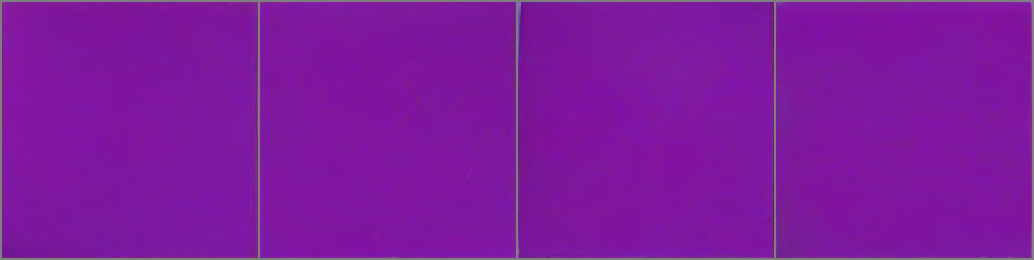

In [23]:
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1)*0.5 + 0.5
Image.fromarray(np.array(im*255).astype(np.uint8))

In [24]:
_empty_cache()

  0%|          | 0/40 [00:00<?, ?it/s]

Step: 0,  loss: 10.51688289642334
Step: 1,  loss: 8.70293140411377
Step: 2,  loss: 7.400426864624023
Step: 3,  loss: 6.457273960113525
Step: 4,  loss: 5.76900577545166
Step: 5,  loss: 5.122627258300781
Step: 6,  loss: 4.60984468460083
Step: 7,  loss: 4.311728477478027
Step: 8,  loss: 4.079234600067139
Step: 9,  loss: 3.9648218154907227
Step: 10,  loss: 3.847500801086426
Step: 11,  loss: 3.7732455730438232
Step: 12,  loss: 3.7118804454803467
Step: 13,  loss: 3.6664743423461914
Step: 14,  loss: 3.639772891998291
Step: 15,  loss: 3.617490291595459
Step: 16,  loss: 3.605752944946289
Step: 17,  loss: 3.599102020263672
Step: 18,  loss: 3.589336395263672
Step: 19,  loss: 3.580220937728882
Step: 20,  loss: 3.571033000946045
Step: 21,  loss: 3.5638487339019775
Step: 22,  loss: 3.556466579437256
Step: 23,  loss: 3.5513973236083984
Step: 24,  loss: 3.5436997413635254
Step: 25,  loss: 3.5402731895446777
Step: 26,  loss: 3.53424072265625
Step: 27,  loss: 3.5306663513183594
Step: 28,  loss: 3.529406

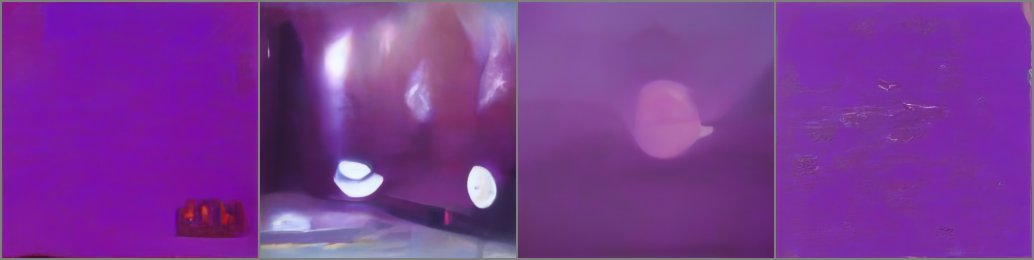

In [25]:
%%time

guidance_loss_scale = 20

x = torch.randn(4, 3, 256, 256).to(device)

for i, t in enumerate(tqdm(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = pipeline.unet(model_input, t)["sample"]

    x = x.detach().requires_grad_()
    
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample
    
    loss = color_loss(x0, (0.5, 0.1, 0.6))*guidance_loss_scale
    print(f"Step: {i},  loss: {loss.item()}")
    
    cond_grad = -torch.autograd.grad(loss, x)[0]
    x = x.detach() + cond_grad
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1)*0.5 + 0.5
Image.fromarray(np.array(im*255).astype(np.uint8))